## How the pipeline works:
1. Preprocess the data with `preprocess`
2. Run voice conversion with `voice_conversion` to get converted audio
3. Run ASR with `asr` to get original transcript and converted transcript
4. Compute metrics with `compute_metrics` to get similarity, WER, and EER scores.
5. (optional) Graph the results

In [26]:
import logging
from src.preprocessing import preprocess
from src.voice_conversion import voice_convert
from src.automatic_speech_recognition import asr
from src.speaker_verification import process_data_to_embeddings, compute_metrics
from src.utils import CODEBASE_DIR
from src.results import visualize_metrics
from datasets import load_from_disk
import os
import numpy as np

logging.getLogger('numba').setLevel(logging.INFO)
from datasets import disable_caching
disable_caching()

In [3]:
raw_data_path = f'{CODEBASE_DIR}/data/raw/LibriTTS/dev-clean'
processed_data_path = f'{CODEBASE_DIR}/data/processed/LibriTTS-dev-clean-16khz-mono-loudnorm'
transcript_path_pattern = "{base_name}.original.txt"
speaker_id_pattern = r"(\d+)_"
target_sample_rate = 16000
num_samples = 100
dataset_name = f"azain/LibriTTS-dev-clean-100-samples"
split = 'dev'
file_extensions = ['.wav']
target_index = 0
asr_model_id = "openai/whisper-tiny.en"

1. Preprocess.

In [4]:
dataset_disk_path = f"{processed_data_path}-dataset"
if os.path.exists(dataset_disk_path):
    dataset = load_from_disk(dataset_disk_path)
else:
    dataset = preprocess(
        raw_data_path, processed_data_path, transcript_path_pattern, speaker_id_pattern, 
        target_sample_rate, num_samples, file_extensions
    )
    dataset.save_to_disk(dataset_disk_path)


In [5]:
dataset.column_names

['audio', 'transcript', 'speaker_id']

In [6]:
dataset[0]

{'audio': {'path': '6313_66125_000027_000000.wav',
  'array': array([-0.00136568, -0.0013324 , -0.00047209, ..., -0.00102548,
          0.00135622,  0.00072142]),
  'sampling_rate': 16000},
 'transcript': 'The mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of its slipping over the shoulders of a man.',
 'speaker_id': '6313'}

2. Voice convert

In [7]:
if os.path.exists(f"{dataset_disk_path}-converted"):
    converted_dataset = load_from_disk(f'{dataset_disk_path}-converted')
else:
    converted_dataset = voice_convert(dataset, target_index)
    converted_dataset.save_to_disk(f'{dataset_disk_path}-converted')

In [8]:
converted_dataset.column_names

['audio', 'transcript', 'speaker_id']

In [9]:
converted_dataset[0]

{'audio': {'path': None,
  'array': array([0.00061035, 0.00076294, 0.00042725, ..., 0.00299072, 0.00234985,
         0.00170898]),
  'sampling_rate': 16000},
 'transcript': 'The mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of its slipping over the shoulders of a man.',
 'speaker_id': '6313'}

3. ASR

In [10]:
if os.path.exists(f"{dataset_disk_path}-asr"):
    orig_dataset_after_asr = load_from_disk(f'{dataset_disk_path}-asr')
else:
    orig_dataset_after_asr = asr(asr_model_id, dataset, split)
    orig_dataset_after_asr.save_to_disk(f"{dataset_disk_path}-asr")

In [11]:
orig_dataset_after_asr.column_names

['audio', 'transcript', 'speaker_id', 'asr_transcription']

In [12]:
orig_dataset_after_asr[0]

{'audio': {'path': None,
  'array': array([-0.00137329, -0.00134277, -0.00048828, ..., -0.0010376 ,
          0.00134277,  0.0007019 ]),
  'sampling_rate': 16000},
 'transcript': 'The mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of its slipping over the shoulders of a man.',
 'speaker_id': '6313',
 'asr_transcription': {'text': ' the mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of it slipping over the shoulders of a man.'}}

In [13]:
if os.path.exists(f"{dataset_disk_path}-converted-after-asr"):
    converted_dataset_after_asr = load_from_disk(f'{dataset_disk_path}-converted-after-asr')
else:
    converted_dataset_after_asr = asr(asr_model_id, converted_dataset, split)
    converted_dataset_after_asr.save_to_disk(f'{dataset_disk_path}-converted-after-asr')

In [14]:
converted_dataset_after_asr.column_names

['audio', 'transcript', 'speaker_id', 'asr_transcription']

In [15]:
converted_dataset_after_asr[0]

{'audio': {'path': None,
  'array': array([0.00039673, 0.00042725, 0.0010376 , ..., 0.00531006, 0.00747681,
         0.00619507]),
  'sampling_rate': 16000},
 'transcript': 'The mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of its slipping over the shoulders of a man.',
 'speaker_id': '6313',
 'asr_transcription': {'text': ' the matineer quickly formed a loop in one end of the rope, making it large enough to permit of its slipping over the shoulders of a man.'}}

In [16]:
def add_anon_columns(anon_dataset, target_dataset):
    """
    Extracts the audio array and asr_transcription from the source dataset and adds it as a new column
    in the target dataset.
    
    Args:
        source_dataset (Dataset): The dataset from which to extract the audio arrays.
        target_dataset (Dataset): The dataset to which the 'converted_audio_waveform' column will be added.
    
    Returns:
        Dataset: The updated target dataset with the new 'converted_audio_waveform' and 'asr_transcription_anon' columns.
    """

    audio_waveform_data = anon_dataset.map(lambda example: {'converted_audio_waveform': example['audio']['array']})
    anon_transcription = anon_dataset.map(lambda example: {'asr_transcription_anon': example['asr_transcription']})
    assert len(audio_waveform_data) == len(target_dataset), "Source and target datasets must be of the same length."

    target_dataset = target_dataset.add_column('converted_audio_waveform', audio_waveform_data['converted_audio_waveform'])
    target_dataset = target_dataset.add_column('asr_transcription_anon', anon_transcription['asr_transcription_anon'])
    
    return target_dataset

In [17]:
updated_dataset = add_anon_columns(converted_dataset_after_asr, orig_dataset_after_asr)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: /tmp/hf_datasets-1m4obmer/tmpag7p2575


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: /tmp/hf_datasets-1m4obmer/tmpf09fa_sj


Map: 100%|██████████| 100/100 [00:00<00:00, 5972.07 examples/s]


In [18]:
updated_dataset.column_names

['audio',
 'transcript',
 'speaker_id',
 'asr_transcription',
 'converted_audio_waveform',
 'asr_transcription_anon']

In [19]:
updated_dataset[0]

{'audio': {'path': None,
  'array': array([-0.00137329, -0.00134277, -0.00048828, ..., -0.0010376 ,
          0.00134277,  0.0007019 ]),
  'sampling_rate': 16000},
 'transcript': 'The mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of its slipping over the shoulders of a man.',
 'speaker_id': '6313',
 'asr_transcription': {'text': ' the mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of it slipping over the shoulders of a man.'},
 'converted_audio_waveform': [0.000396728515625,
  0.00042724609375,
  0.00103759765625,
  0.0006103515625,
  0.000152587890625,
  0.000823974609375,
  0.000244140625,
  -3.0517578125e-05,
  0.000579833984375,
  0.000335693359375,
  0.000396728515625,
  0.00079345703125,
  0.000701904296875,
  0.000244140625,
  -3.0517578125e-05,
  0.000640869140625,
  0.000732421875,
  0.0008544921875,
  0.000640869140625,
  0.000579833984375,
  0.001312255859375,
  0.001983642578125,
  0.00

In [20]:
if os.path.exists(f"{dataset_disk_path}-embeddings"):
    embeddings = load_from_disk(f"{dataset_disk_path}-embeddings")
else:
    embeddings = process_data_to_embeddings(updated_dataset)
    embeddings.save_to_disk(f"{dataset_disk_path}-embeddings")

In [21]:
embeddings.column_names

['audio',
 'transcript',
 'speaker_id',
 'asr_transcription',
 'converted_audio_waveform',
 'asr_transcription_anon',
 'embeddings',
 'anonymized_embeddings']

In [22]:
embeddings[0]

{'audio': {'path': None,
  'array': array([-0.00137329, -0.00134277, -0.00048828, ..., -0.0010376 ,
          0.00134277,  0.0007019 ]),
  'sampling_rate': 16000},
 'transcript': 'The mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of its slipping over the shoulders of a man.',
 'speaker_id': '6313',
 'asr_transcription': {'text': ' the mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of it slipping over the shoulders of a man.'},
 'converted_audio_waveform': [0.000396728515625,
  0.00042724609375,
  0.00103759765625,
  0.0006103515625,
  0.000152587890625,
  0.000823974609375,
  0.000244140625,
  -3.0517578125e-05,
  0.000579833984375,
  0.000335693359375,
  0.000396728515625,
  0.00079345703125,
  0.000701904296875,
  0.000244140625,
  -3.0517578125e-05,
  0.000640869140625,
  0.000732421875,
  0.0008544921875,
  0.000640869140625,
  0.000579833984375,
  0.001312255859375,
  0.001983642578125,
  0.00

In [23]:
import json
if os.path.exists(f"{dataset_disk_path}-similarities") and os.path.exists(f"{dataset_disk_path}-metrics.json"):
    similarities = load_from_disk(f"{dataset_disk_path}-similarities")
    with open(f"{dataset_disk_path}-metrics.json") as f:
        rest_metrics = json.load(f)
    metrics = {'similarities': similarities} | rest_metrics
else:
    metrics = compute_metrics(embeddings)
    metrics['similarities'].save_to_disk(f"{dataset_disk_path}-similarities")
    with open(f"{dataset_disk_path}-metrics.json", "w") as f:
        json.dump({k: v for k, v in metrics.items() if k != 'similarities'}, f, indent=4)

In [24]:
metrics

{'similarities': Dataset({
     features: ['same_speaker', 'orig_orig_similarity_score', 'orig_anon_similarity_score', 'anon_anon_similarity_score'],
     num_rows: 4950
 }),
 'orig_wer_score': 0.18932874500751495,
 'anon_wer_score': 0.13238771259784698,
 'eer_scores': {'orig_orig': [0.056532686576247215, 0.24713380634784698],
  'orig_anon': [0.4301721900701523, 0.1599230319261551],
  'anon_anon': [0.42901988327503204, 0.626667320728302]}}

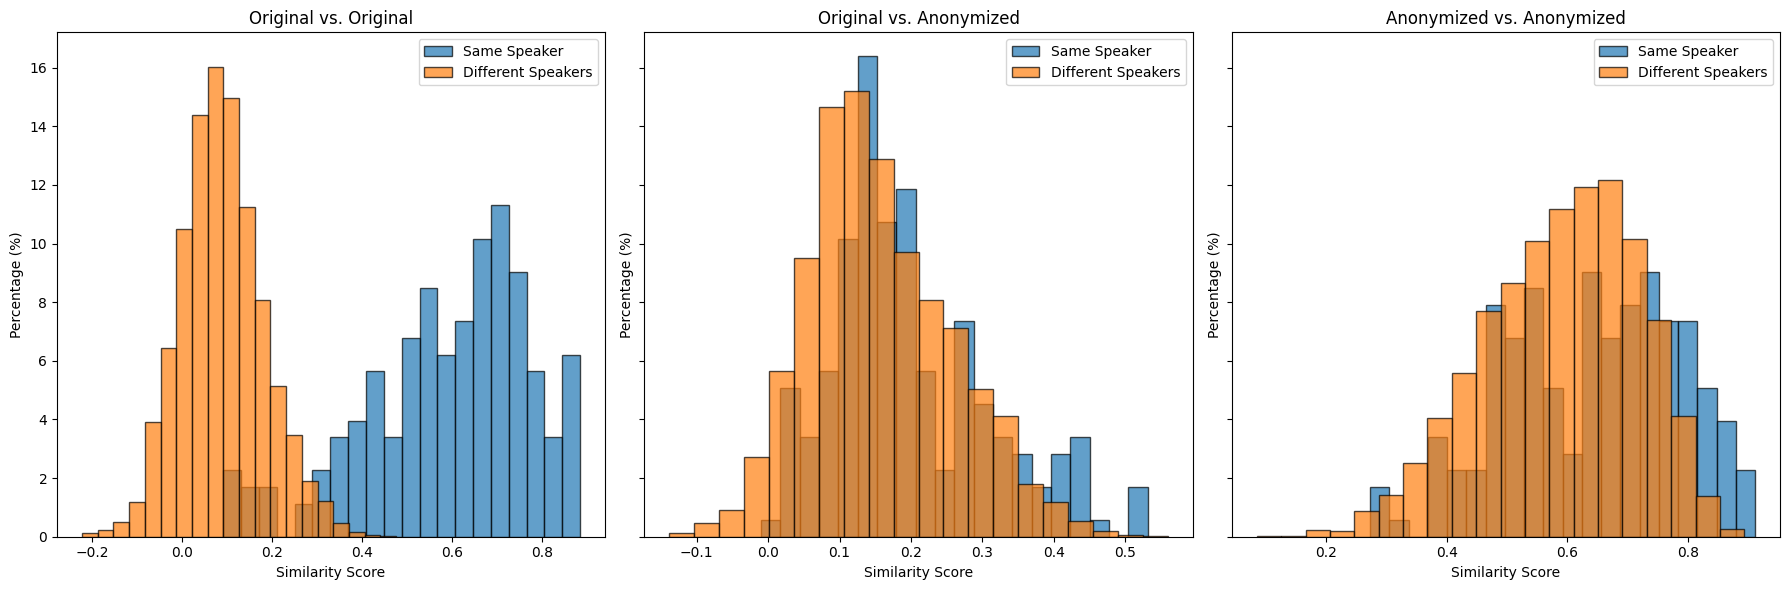

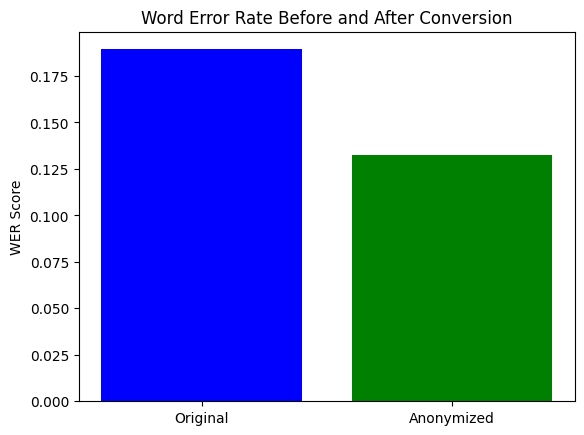

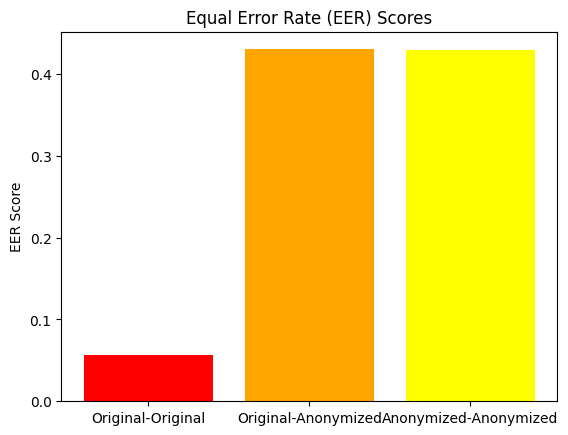

In [27]:
visualize_metrics(metrics)